<a href="https://colab.research.google.com/github/TAMIDSpiyalong/ECEN-689/blob/main/Day4c.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mask RCNN Application in Precision Livestock Farming





This lab is based on a TAMIDS project that aims to sense cattle feeding time using MaskRCNN. You can find all the details about this project here [paper](https://www.preprints.org/manuscript/202307.0705/v1). To learn more about the model: https://pytorch.org/vision/main/models/mask_rcnn.html



## Background

Feeding behavior in livestock operations plays a crucial role in determining economic efficiency and ensuring the health and well-being of group-fed animals. Accurate and cost-effective methods for monitoring feeding behavior are essential for optimizing feed costs and detecting health issues. Due to the high cost of equipment and maintenance, many farmer do not have a good way to monitor this data. In this lab, we propose the use Mask RCNN to detect pen-fed beef cattle feeding behavior using cheap cameras and computers.

## Objectives

1. Apply a pre-trained Mask RCNN model on the animal video and generate mask segmentations.
2. Define bunk locations and derive feeding time for each bunk accurately.
3. Compare the computer vision results with the corresponding physical sensor data to measure the accuracy.

In [46]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
import csv
import json
import pandas as pd
import os
from sklearn.metrics import confusion_matrix,classification_report,precision_score, recall_score,precision_recall_curve,f1_score
from torchvision.io import read_image,read_video
from torchvision.transforms.functional import convert_image_dtype
from torchvision.utils import draw_bounding_boxes,draw_segmentation_masks
from torchvision.models.detection import maskrcnn_resnet50_fpn #importing libraries and models


## Pre-trained Model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)#checking for and storing gpu

cuda


COCO dataset contains 80 classes, but their class indices are not contiguous, resulting in several "N/A" classes in the list. To address this issue, one approach is to consider the maximum class id, which in this case is 90, resulting in a total of 91 classes.

This approach simplifies the code as there is no need to maintain a class mapping, similar to what torchvision also does. By using the maximum class id, the code becomes more straightforward and eliminates the need for additional complexities present in maskrcnn-benchmark or detectron2.

In [29]:
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]


In [25]:
CLASSES[21]

'cow'

In [30]:
len(CLASSES)

91

In [14]:
model = maskrcnn_resnet50_fpn(pretrained=True) #defining the model based on pretrained values
model.to(device)
model = model.eval()

In [28]:
inst_class_to_idx = {cls: idx for (idx, cls) in enumerate(CLASSES)}

## Show Visualization

The code snippet is reading an image using OpenCV’s cv2.imread() function and then reading bunk data from a JSON file using Python’s built-in json.load() function. Finally, it is annotating bunks in the image and drawing bunk lines using OpenCV’s cv2.putText() and cv2.polylines() functions respectively to visualize bunk location accuracy.



FileNotFoundError: ignored

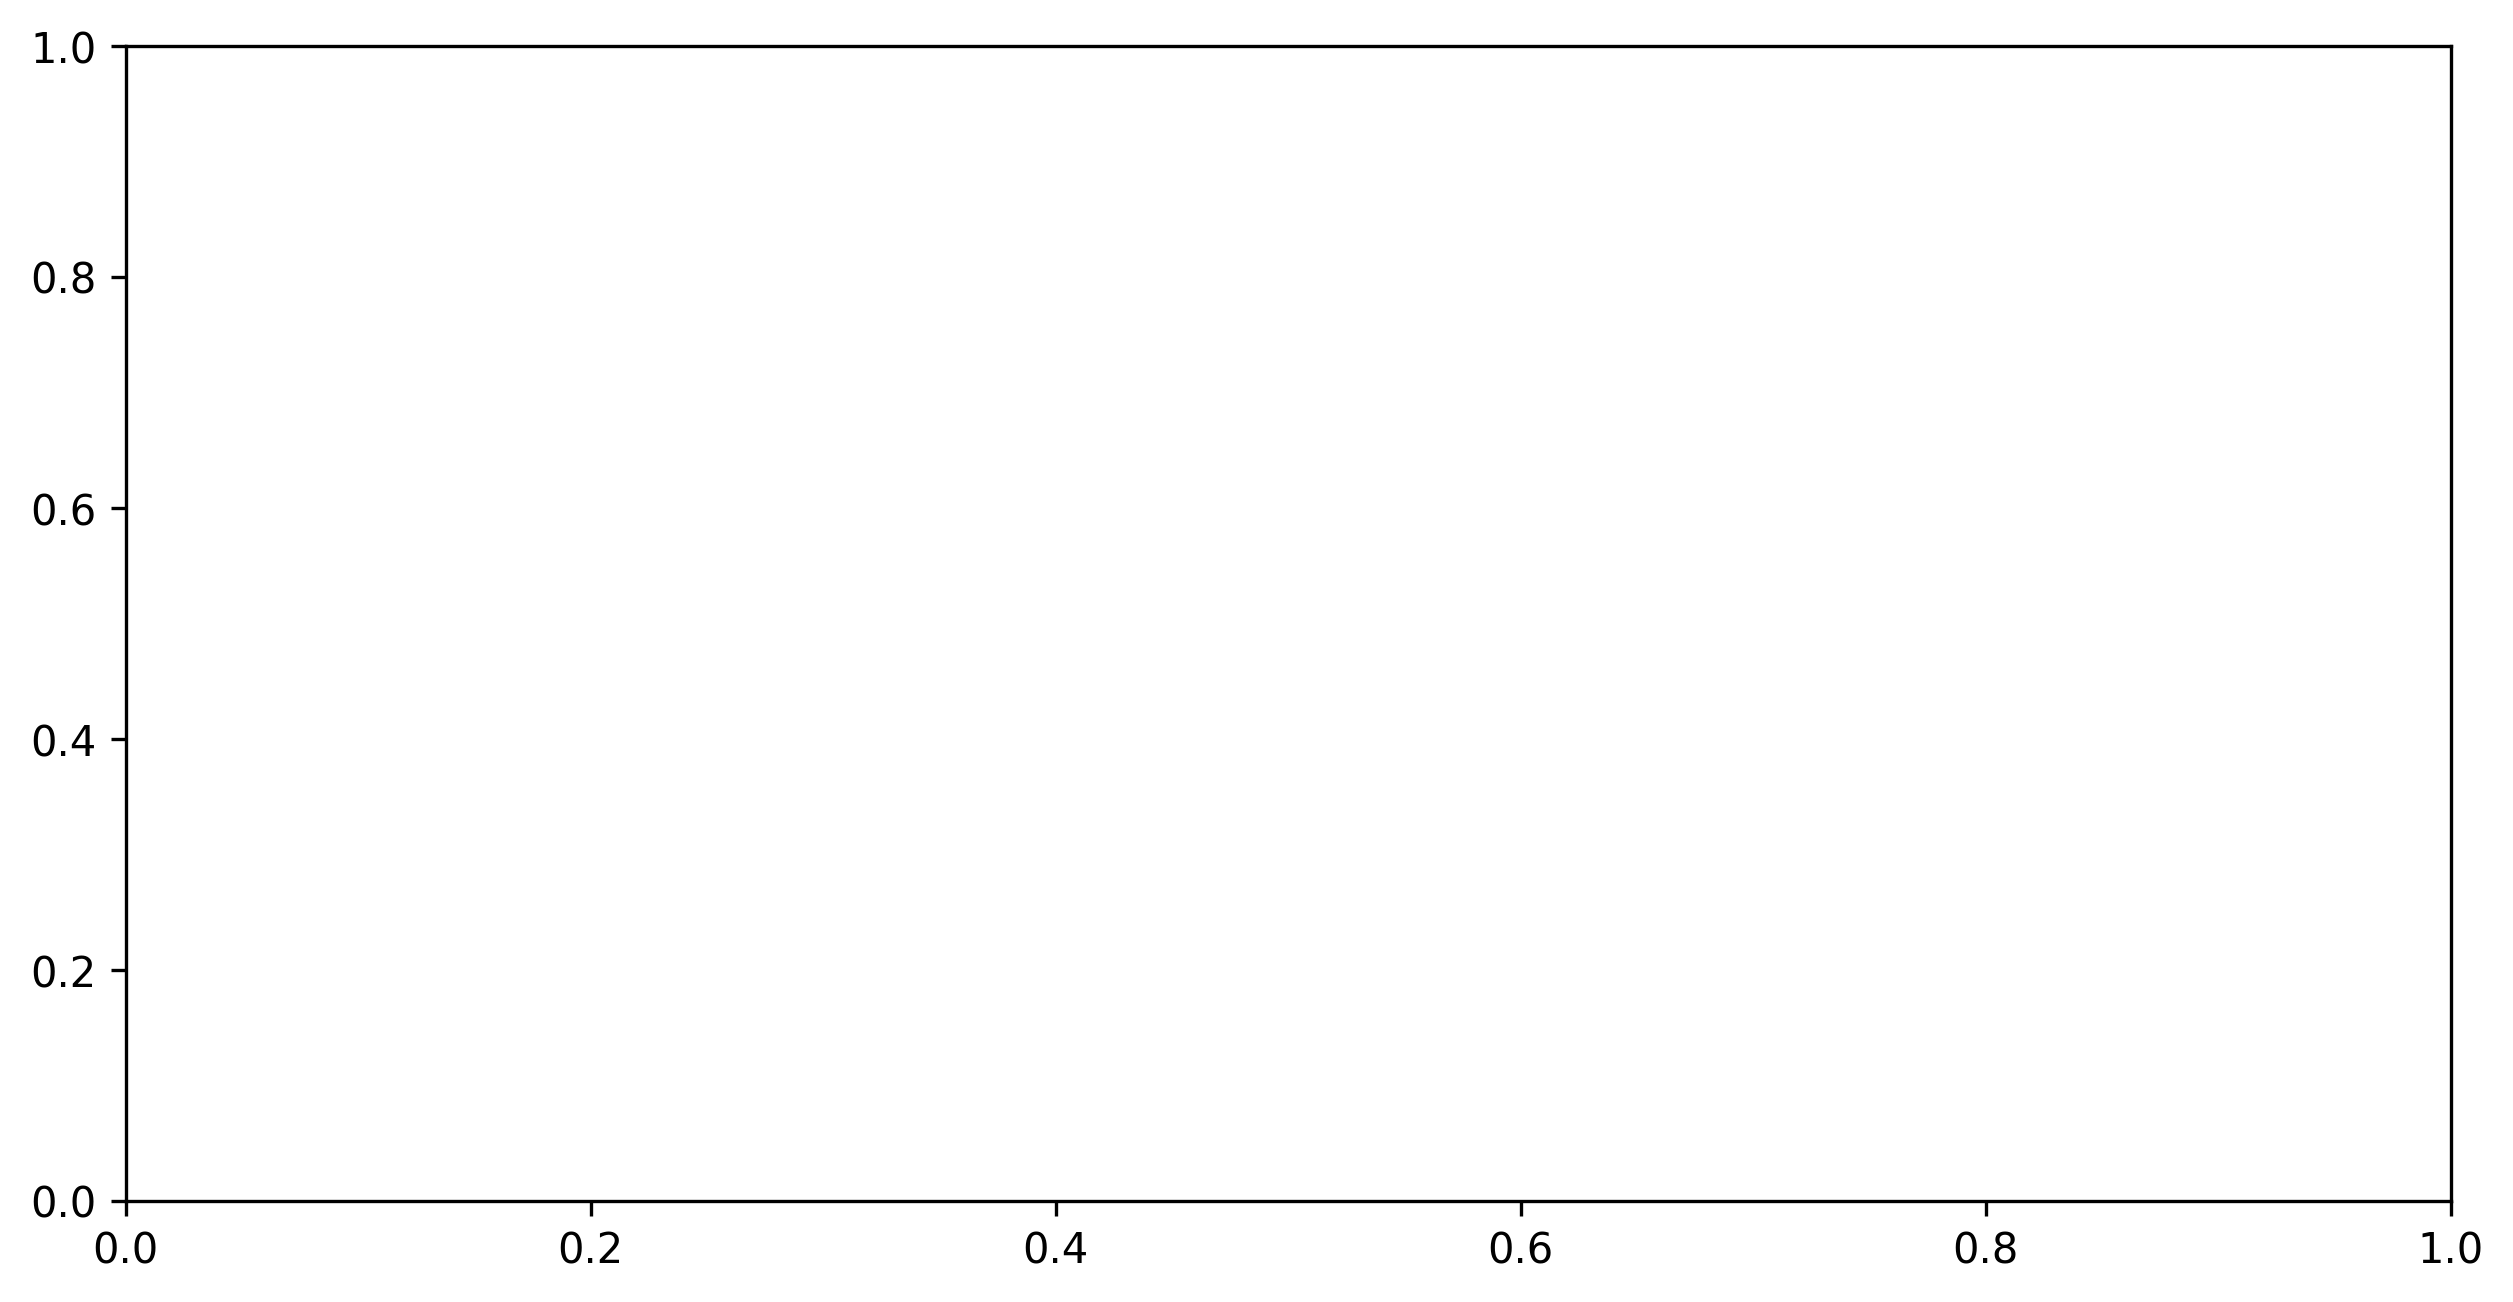

In [ ]:
fig, ax = plt.subplots(figsize=(10,5),dpi=300)        #sample image visualization to check model


img = cv2.imread("cg_image.jpg")   # reading image
studyzones='callan_gates_json.json'       #reading json for bunk data

pixelzones = {}
with open(studyzones, 'r') as json_file:    #storing bunks data
    zones = json.load(json_file)
    for each in (zones['shapes']):
        pixelzones.update({each['label']:each['points']})
for zonename,check_zone in pixelzones.items():   #annotating bunks in image and drawing bunk lines
    pts = np.array(check_zone, np.int32)

    p1,p2 = (pts[0],pts[1])
    im=cv2.putText(img,zonename,tuple((np.array([int(x) for x in p1])+np.array([int(x) for x in p2]))//2),cv2.FONT_HERSHEY_SIMPLEX,1, (255,255,255), 3)

    pts = pts.reshape((-1, 1, 2))
    im=cv2.polylines(img,[pts],True,(0,255,255),5)
plt.imshow(im)            #displaying images


# Generating feed time from mask overlap

The code snippet below reads all mp4 video files in the directory. If it is a mp4 file, it prints the name of the file. Then it initializes score_threshold and proba_threshold based on the optimal grid search values. It also initializes two dictionaries mask_data and feed_time and sets frame_number to 0.

Then it enters a while loop that reads each frame of the video file until there are no more frames left. For each frame, it updates the feed_time dictionary with an empty list for that frame number. It reads the frame from the video capture object and converts it from BGR to RGB format. It then transforms the image for use with the PyTorch model and runs it through the model to get the mask and box output.

It then selects only those boxes with label 21 (cow) and probability greater than score_threshold. It also selects only those masks with probability greater than proba_threshold.  Finally, it stores information about these masks in the masks_data dictionary.

It then iterates over each bunk  in the pixelzones dictionary and checks if there is any overlap between the bunk mask and the cow mask. If there is overlap, it stores the zone name in the feed_time dictionary for that frame number.

Example of feeding detection:

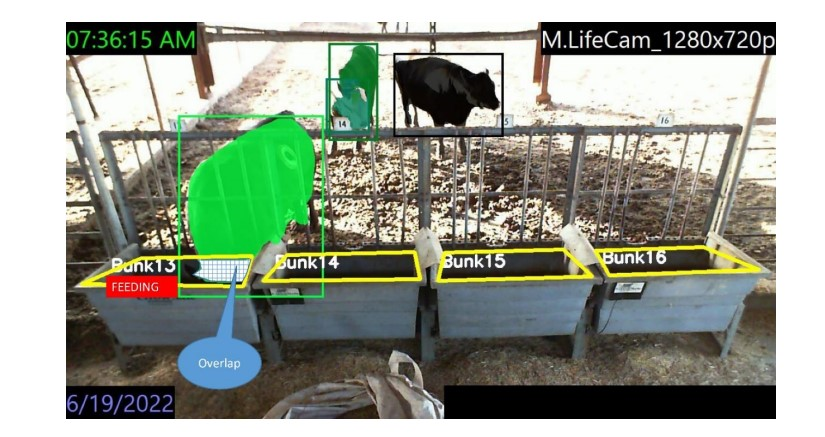

In [ ]:
for filet in os.listdir(cwd):   # The directory where we want to run
    if '.mp4' in filet:                                                              #checking for video file and printing name
        print(filet)

        file_path=filet
        video_capture = cv2.VideoCapture(file_path)     # for video capture
        w = int(video_capture.get(3))
        h = int(video_capture.get(4))
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        fps = int(video_capture.get(cv2.CAP_PROP_FPS))


        score_threshold = 0.1               # box threshold of 0.1 is selected for box generation
        proba_threshold = 0.7               # mask threshold of 0.7 is selected for mask generation

        mask_data={}                        #initializing the mask_data file to be empty
        feed_time = {}
        frame_number=0                      # frame number to store mask data for each frame sequentially
        while True:
            feed_time.update({frame_number:[]})
            ret, frame = video_capture.read()  # frame shape 640*480*3
            if ret != True:
                break
            imgtest = frame[:, :, ::-1].transpose(2, 0, 1)  # BGR to RGB, to 3x416x416
            imgtest = np.ascontiguousarray(imgtest)          #image transformation for model
            imgtest  = torch.from_numpy(imgtest)
            batch_int = torch.stack([imgtest])
            batch = convert_image_dtype(batch_int, dtype=torch.float)

            batch = batch.to(device)                        # for gpu


            output = model(batch)                           # for gpu
            index = torch.logical_and(output[0]['labels'].detach().cpu() == 21, output[0]['scores'].detach().cpu() > score_threshold)
                    # index of boxes with probability greater than box threshold with label 21(cow)

            masks = output[0]['masks'][index].detach().cpu() > proba_threshold

            # storing information of masks with probability better than mask threshold
            masksnp = masks.numpy()

            mask2= masks.to(device)

            for zonename,check_zone in pixelzones.items():
                pts = np.array(check_zone, np.int32)    #Put text and polygon lines
                p1,p2,p3,p4 = pts
                ptss = pts.reshape((-1, 1, 2))
                bunk_mask =  np.zeros((h,w))
                bunk_mask = cv2.fillPoly(bunk_mask, np.array([pts]).astype("int"), 1) # Build a mask for each bunk

                bunk_mask2 = torch.from_numpy(bunk_mask).to(device) # bunk mask to pytorch cpu/gpu if applicable

                combined = bunk_mask2+mask2 # combining to check for overlap between bunk and animal mask
                unique, counts = torch.unique(combined, return_counts=True)  # checking for overlap between bunk and animal mask
                unique  = unique.detach().cpu().numpy()   # storing unique data in numpy cpu
                counts  = counts.detach().cpu().numpy()   # storing count data in numpy cpu

                if 2 in dict(zip(unique, counts)).keys():  # if overlap then store zone name
                    feed_time[frame_number].append([zonename])


            frame_number+=1      #updating frame number for next iteration/frame

            #print(frame_number)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        cv2.destroyAllWindows()



        np.save(file_path[:-4]+'_feed_time.npy',feed_time)



# Read data from the physical sensor as ground truth (GT)


Reading ground truth sensor data and storing flag variable when sensor readings indicate feeding

In [ ]:
sensors = pd.read_csv("2023-06-10_OUTPUT_SENSORS.csv")


In [ ]:
sensorsd =  sensors[sensors['Sensor Name'].str.contains("DT")].copy()
sensorsm =  sensors[sensors['Sensor Name'].str.contains("MN")].copy()
sensorsd.loc[:, 'id'] = sensorsd['Sensor Name'].str.strip().str[-1]
sensorsm.loc[:, 'id'] = sensorsm['Sensor Name'].str.strip().str[-1]
sensorsdm = sensorsd.merge(sensorsm, left_on=['Time','id'], right_on = ['Time','id'])
sensorsdm['flag'] = (sensorsdm['Sensor Value_x'] < 15) & (sensorsdm['Sensor Value_y'] < 1)

# Plot GT of one scale on one date

The code filters the data based on the scale number. Then it converts the flag column to an integer type and the Time column to a datetime type. Then it sets the index of the dataframe to Time and then filters it to include only the first 99000 rows. Finally, it resamples the data by hour and aggregates it by summing up the flag column and then plots it as a bar chart to get the ground truth feeding plot

In [ ]:
scale_number=6
scales  = sensorsdm.copy()
scale = scales.loc[scales['id']==str(scale_number)].copy()

#filtering based on scale number
scale['flag'] = scale['flag'].astype(int)
scale['Time'] = pd.to_datetime(scale['Date_x']+' '+scale['Time'])

ax=scale.set_index('Time').iloc[1:99000].resample('60min').agg('sum')['flag'].plot.bar()

ax.set_xlabel("Time")
ax.set_ylabel("Feeding seconds GT")

# CONVERTING FEED TIME PREDICTIONS TO BUNK + TIME FORMAT



The code filters the feed time npy files based on the name and extension of the file. It then loads the data from the file and extracts the time information from the file name. It creates a pandas dataframe with the start time of the video and calculates the end time of the video using the delta value. It then stores the video time from start to end at frame speed in a list. Finally, it loops through each bunk and each frame number to check for feeding at each bunk and stores it in a list.

In [ ]:
fps=30                #frames per second of video
video_window=[]       # to store video time information
cv_timear=[]          # to store computer vision imformation at bunk*frame level
for file in os.listdir(cwd):   #directory of analysis
    if 'feed_time' in file:               # filtering feed time files which were generated in ft function
        if '.npy' in file:                # filtering npy files
            print(file)
            time_data  =  np.load(file,allow_pickle=True).item()
            idx=file.find('-')
            hour = file[idx+1:idx+3]
            minute = file[idx+3:idx+5]
            second = file[idx+5:idx+7]

            df = pd.DataFrame( {"year": [2023], "month": [6], "day": [10], "hour": [int(hour)],"minute":[int(minute)],"second":[int(second)]})

            start = pd.to_datetime(df)             # start time same as video title
            delta = list(time_data.keys())[-1]/fps    # delta to find end time
            end = start+pd.Timedelta(delta,"seconds")
            video_window.extend(pd.date_range(start[0], end[0],freq='1000ms')) # storing video time from start to end at frame speed


            for i in ['Bunk5','Bunk6']: # to check for feeding at each bunk
                for k, v in time_data.items():
                    s = k/fps
                    if k%30 == 0:
                        current_time = start[0]+pd.Timedelta(s,"seconds")  # current time based on frame number and fps
                        if [i] in v:
                            cv_timear.append([i+str(current_time),1])  # if bunk exists in feeding then store bunk*frame_number as 1
                        else:
                            cv_timear.append([i+str(current_time),0]) # if bunk does not exists in feeding then store bunk*frame_number as 0


# CONVERTING GROUND TRUTH TO BUNK + TIME FORMAT

The code  is looping through each bunk to check for feeding at each bunk. It filters the data based on the scale number and converts the flag column to an integer type and the Time column to a datetime type. It then filters the data based on the flag value and stores the time information in a list. Finally, it loops through each frame in the video window and checks if it exists in the ground truth data. If it exists, it stores bunkframe_number as 1, otherwise it stores bunkframe_number as 0.

The variable gt=[] is an empty list that is used to store the ground truth data.

In [ ]:
gt=[]

for i in ['Bunk5','Bunk6']:  # to check for feeding at each bunk
    print(i)
    scale_number=i[-1]
    scales  = sensorsdm.copy()
    scale = scales.loc[scales['id']==str(scale_number)].copy()   #filtering based on scale number
    scale['flag'] = scale['flag'].astype(int)
    scale['Time'] = pd.to_datetime(scale['Date_x']+' '+scale['Time'])

    total_gtdf= scale[scale['flag']==1]["Time"]
    total_gt = total_gtdf.tolist()

    for each in video_window:
        if each in total_gt:
            gt.append([i+str(each),1])
        else:                         # if feeding does not exists in ground truth then store bunk*frame_number as 0
            gt.append([i+str(each),0])

# METRICS AND PLOTS

The code is creating two dataframes of gt and cv prediction. It then merges the two dataframes for comparison at bunk*frame level and sorts the data. It calculates the precision, recall, f_score and confusion matrix based on gt and cv.

In [ ]:
rt=cv_timear
gtpd = pd.DataFrame(gt)  # creating dataframe of gt prediction
rtpd = pd.DataFrame(rt)  # creating dataframe of cv prediction
gtpd.columns = ['key', 'value']
rtpd.columns = ['key', 'value']
grtpd=gtpd.merge(rtpd, on='key', how='inner')    #merging gt and cv for comparison at bunk*frame level
grtpd=grtpd.sort_values(by=['key'])              #sorting data
grtpd.to_csv('grtpd.csv')


In [ ]:
precision = []                  #calculating the precision, recall, f_score and confusion matrix based on gt and cv
recall = []
threshold = []
f_score = []
cm = []

precision.append( precision_score(grtpd['value_x'],grtpd['value_y']))
recall.append( recall_score(grtpd['value_x'],grtpd['value_y']))
threshold.append(i)
f_score.append(f1_score(grtpd['value_x'],grtpd['value_y']))
cm.append(confusion_matrix(grtpd['value_x'],grtpd['value_y']))


In [ ]:
cm

In [ ]:
precision

In [ ]:
recall

The code creates a confusion matrix and recall score for each bunk. The code reads data from two dataframes grtpd and creates two new dataframes gtt and cvt. It then filters the data for each bunk and drops temporary columns. It then creates a confusion matrix at bunk level, recall at bunk level, and precision at bunk level. It then resamples the data at 2min level for only the given data and creates a bar chart of ground truth and CV.

In [ ]:
for i in ['Bunk5','Bunk6']: # for each bunk
    Bunk = i
    print(i)
    gtt=grtpd[['key','value_x']]    # creating new dataframes to store bunk level gt and cv
    cvt=grtpd[['key','value_y']]
    gtt[2]=gtt['key'].str[:5]      # reading the bunk name in gtt[2]
    gtt[3]=gtt['key'].str[5:]      # reading the timestamp in gtt[3]
    gtt['key']=gtt[3]              # creating new key for bunk based on timestamp
    gtt=gtt.loc[gtt[2] == Bunk]    #filtering for bunk based on i
    gttt = gtt.drop([2,3],axis=1)  #dropping temporary columns
    gttt['key'] = pd.to_datetime(gttt['key'])  # converting new key to timestamp format

    cvt[2]=cvt['key'].str[:5]      # reading the bunk name in cvt[2]
    cvt[3]=cvt['key'].str[5:]      # reading the timestamp in cvt[3]
    cvt['key']=cvt[3]              # creating new key for bunk based on timestamp
    cvt=cvt.loc[cvt[2] == Bunk]    #filtering for bunk based on i
    cvtt = cvt.drop([2,3],axis=1)  #dropping temporary columns
    cvtt['key'] = pd.to_datetime(cvtt['key'])  # converting new key to timestamp format

    print(confusion_matrix(gttt['value_x'],cvtt['value_y'])) # confusion matrix at bunk level
    print(recall_score(gttt['value_x'],cvtt['value_y']))     # recall at bunk level
    print(precision_score(gttt['value_x'],cvtt['value_y']))  # precision at bunk level

    gttt['ck']=1                                         #resampling at 2min level for only the given data
    gsamp= gttt.set_index('key').iloc[1:99000].resample('2min').agg('sum')
    gsamp = gsamp[gsamp['ck']>0]

    cvtt['ck']=1                                         #resampling at 2min level for only the given data
    csamp= cvtt.set_index('key').iloc[1:99000].resample('2min').agg('sum')
    csamp = csamp[csamp['ck']>0]

    gsamp['ck'] = csamp['value_y']                      # gsamp to compare ground truth and cv
    gsamp.columns = ['Ground Truth', 'CV']
    ax=gsamp.plot.bar(title='Ground and CV ')
    ax.set_xlabel("Time")
    ax.set_ylabel("Frame count")
    ax.set_title("{}  Aggregated Feeding Frequency (2 minute) Comparison at 0.1 Box and 0.7 Mask Threshold".format(i))
    fig = ax.get_figure()




